In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import pandas as pd
from dask.distributed import Client, LocalCluster, get_task_stream
import xarray as xr
import glob
from numba import jit, guvectorize, float32, float64, boolean

In [2]:
%config Completer.use_jedi = False

In [3]:
#sns.set_style('whitegrid')
#plt.style.use(['seaborn-whitegrid','seaborn-poster','plotstyle.mplstyle'])
mpl.rcParams.update({'font.size': 18})
xr.set_options(keep_attrs=True,display_style='html')

In [4]:
@guvectorize(
    [
        (float64[:], float64[:], float64[:], boolean, float64[:]),
        (float32[:], float32[:], float32[:], boolean, float32[:]),
    ],
    "(n),(n),(m),()->(m)",
    nopython=True,
)
def _interp_1d_linear(phi, theta, target_theta_levels, mask_edges, output):
    # if last theta value is smaller than first, assume the profile is monotonically decreasing and flip
    if theta[-1] < theta[0]:
        theta = np.flip(theta)
        phi = np.flip(phi)

    output[:] = np.interp(target_theta_levels, theta, phi)

    if mask_edges:
        theta_max = np.nanmax(theta)
        theta_min = np.nanmin(theta)
        for i in range(len(target_theta_levels)):
            theta_lev = target_theta_levels[i]
            if (theta_lev < theta_min) or (theta_lev > theta_max):
                output[i] = np.nan


def interp_1d_linear(phi, theta, target_theta_levels, mask_edges=False):
    """
    Vectorized interpolation of scalar phi to isosurfaces of scalar theta
    along the final axis.
    Parameters
    ----------
    phi : array_like
        Array of shape (..., n), scalar field to be interpolated
    theta : array_like
        Array of shape (..., n), scalar field which defines the isosurfaces
    target_theta_levels : array_like
        Array of shape (m) specificying target isosurface levels
    mask_edges : bool, optional
        Determines how to handle theta values that exceed the bounds of
        target_theta_levels. If False, fill with nearest valid values. If
        True, fill with NaNs.
    Returns
    -------
    phi_interp : array
        Array of shape (..., m) of phi interpolated to theta isosurfaces.
    """
    return _interp_1d_linear(phi, theta, target_theta_levels, mask_edges)


def linear_interpolation(
    phi, theta, target_theta_levels, phi_dim, theta_dim, target_dim, **kwargs):
    out = xr.apply_ufunc(
        interp_1d_linear,
        phi,
        theta,
        target_theta_levels,
        kwargs=kwargs,
        input_core_dims=[[phi_dim], [theta_dim], [target_dim]],
        output_core_dims=[[target_dim]],
        exclude_dims=set((phi_dim,)),
        dask="parallelized",
        output_dtypes=[np.float32],
    )
    out[target_dim] = target_theta_levels
    return out

def cal_integral_within_contours(tracer, contour, var=None,
                                 out_name=None, lt=True):
    """
    Calculate masked variable using pre-calculated tracer contours.
    Parameters
    ----------
    contour : xarray.DataArray
        A given contour levels.
    var  : xarray.DataArray
        A given variable in dset.  If None, area enclosed by contour
        will be calculated and returned
    out_name : str
        A given name for the returned variable.
    lt : boolean
        less than the given contour or greater than.
    Returns
    ----------
    intVar : xarray.DataArray
        The integral of var inside contour.  If None, area enclosed by
        contour will be calculated and returned
    """
    if var is None:
        var = tracer - tracer + 1

    if out_name is None:
        if var is None:
            out_name = 'area'
        else:
            out_name = 'int' + var.name
    print(var.shape)
    print(tracer.shape)
    print(contour.shape)
    if lt:
        mskVar = np.where(tracer < contour, var, np.full_like(var, np.nan))#var.where(tracer < contour)
    else:
        mskVar = np.where(tracer > contour, var, np.full_like(var, np.nan))#var.where(tracer > contour)

    intVar = grid.integrate(mskVar, ['X','Y']).rename(out_name)

    return intVar


In [5]:
timescale = 20
DJF_bool = '_DJFonly'
root_path = '/mnt/nas4.meop2/meop40.data.model/CMAM/0A.daily/'
root_path = '/mnt/data04/model/CMAM/0A.daily/'
cesta = f'{root_path}composites_woSSW{DJF_bool}/'
name = 'himalayas'
lag = 0
a0 = 6376.0e3 # [m]
g = 9.81 #[m/s2 ]

https://github.com/Unidata/MetPy/issues/1479

In [6]:
sel_var_ls = ['vorpot','tpot']
ds_ls = []
for sel_var in sel_var_ls:
    infiles = sorted(glob.glob(f'{root_path}{sel_var}/{sel_var}_6*18.nc'))
    infile = infiles[0]
    print(infile)
    ds = xr.open_dataset(infile)[sel_var]
    #ds = xr.open_mfdataset(infile, concat_dim='time')[sel_var] # dask not supported yet
    ds_ls.append(ds)
    
ds_all = xr.merge(ds_ls)
ds_all

/mnt/data04/model/CMAM/0A.daily/vorpot/vorpot_6hrPlev_CMAM_CMAM30-SD_r1i1p1_1979010100-1979123118.nc
/mnt/data04/model/CMAM/0A.daily/tpot/tpot_6hrPlev_CMAM_CMAM30-SD_r1i1p1_1979010100-1979123118.nc


<xarray.Dataset>
Dimensions:  (lat: 48, lon: 96, plev: 63, time: 1460)
Coordinates:
  * time     (time) object 1979-01-01 00:00:00 ... 1979-12-31 18:00:00
  * plev     (plev) float64 1e+05 9.25e+04 8.5e+04 8e+04 ... 0.2 0.15 0.1 0.07
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
Data variables:
    vorpot   (time, plev, lat, lon) float32 ...
    tpot     (time, plev, lat, lon) float32 ...
Attributes:
    standard_name:     ertel_potential_vorticity
    long_name:         Ertel's Potential Vorticity
    units:             K m2 kg-1 s-1
    cell_methods:      time:mean
    cell_measures:     area: areacella
    history:           2013-05-28T07:40:04Z altered by CMOR: replaced missing...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

In [7]:
vert_c_name = 'plev'
isentlevs = np.arange(400,850,10)

ds_out = linear_interpolation(ds_all['vorpot'], 
                              ds_all['tpot'], 
                              isentlevs,
                              vert_c_name, 
                              vert_c_name, 
                              'lvl')
ds_out

<xarray.DataArray 'vorpot' (time: 1460, lat: 48, lon: 96, lvl: 45)>
array([[[[-1.00253734e-05, -1.08483503e-05, -1.19984851e-05, ...,
          -2.62434196e-04, -2.75508612e-04, -2.88583029e-04],
         [-1.00341333e-05, -1.08650068e-05, -1.20253402e-05, ...,
          -2.62683896e-04, -2.75759866e-04, -2.88835836e-04],
         [-1.00440045e-05, -1.08829530e-05, -1.20527703e-05, ...,
          -2.62907409e-04, -2.75985060e-04, -2.89062711e-04],
         ...,
         [-1.00119918e-05, -1.08148401e-05, -1.19329276e-05, ...,
          -2.61547371e-04, -2.74617714e-04, -2.87688057e-04],
         [-1.00135519e-05, -1.08223296e-05, -1.19510561e-05, ...,
          -2.61863819e-04, -2.74935448e-04, -2.88007077e-04],
         [-1.00182814e-05, -1.08338201e-05, -1.19733236e-05, ...,
          -2.62160168e-04, -2.75233149e-04, -2.88306130e-04]],

        [[-1.24396973e-05, -1.32972732e-05, -1.46738935e-05, ...,
          -2.65178291e-04, -2.78709462e-04, -2.92240632e-04],
         [-1.25787053e-05, -1.34629177e-05, -1.48621702e-05, ...,
          -2.65759158e-04, -2.79258351e-04, -2.92757544e-04],
         [-1.26809498e-05, -1.35948517e-05, -1.50113760e-05, ...,
          -2.66312085e-04, -2.79780012e-04, -2.93247939e-04],
...
         [ 1.27425822e-05,  1.41477780e-05,  1.57338752e-05, ...,
           7.70979846e-04,  8.02392662e-04,  8.33805478e-04],
         [ 1.30644075e-05,  1.44851515e-05,  1.60660600e-05, ...,
           7.64133616e-04,  7.94665520e-04,  8.25197424e-04],
         [ 1.34203502e-05,  1.48708793e-05,  1.64520586e-05, ...,
           7.58816477e-04,  7.88625692e-04,  8.18434908e-04]],

        [[ 1.32711801e-05,  1.47249371e-05,  1.66697855e-05, ...,
           7.43767092e-04,  7.71391991e-04,  7.99016889e-04],
         [ 1.33950097e-05,  1.48721040e-05,  1.68579356e-05, ...,
           7.42402835e-04,  7.70088609e-04,  7.97774383e-04],
         [ 1.35205584e-05,  1.50243650e-05,  1.70551479e-05, ...,
           7.40912806e-04,  7.68676715e-04,  7.96440625e-04],
         ...,
         [ 1.29204586e-05,  1.43232993e-05,  1.61668129e-05, ...,
           7.47049497e-04,  7.74588332e-04,  8.02127166e-04],
         [ 1.30331183e-05,  1.44499159e-05,  1.63238702e-05, ...,
           7.46098519e-04,  7.73651207e-04,  8.01203894e-04],
         [ 1.31502418e-05,  1.45839471e-05,  1.64915833e-05, ...,
           7.45001230e-04,  7.72582099e-04,  8.00162967e-04]]]])
Coordinates:
  * time     (time) object 1979-01-01 00:00:00 ... 1979-12-31 18:00:00
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
  * lvl      (lvl) int64 400 410 420 430 440 450 460 ... 790 800 810 820 830 840
Attributes:
    standard_name:     ertel_potential_vorticity
    long_name:         Ertel's Potential Vorticity
    units:             K m2 kg-1 s-1
    cell_methods:      time:mean
    cell_measures:     area: areacella
    history:           2013-05-28T07:40:04Z altered by CMOR: replaced missing...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

In [3]:
from xcontour import Contour2D, latitude_lengths_at, add_latlon_metrics

# Using xcontour

In [8]:
import sys
sys.path.append('../../')
#from GeoApps.ContourMethods import ContourAnalysisInLatLon
from GeoApps.DiagnosticMethods import Dynamics
#from GeoApps.GridUtils import add_latlon_metrics
from xcontour import Contour2D, latitude_lengths_at, add_latlon_metrics

In [10]:
#dset=isent_data_xr.rename({'lat':"latitude", "lon": "longitude"}).metpy.dequantify()
dset=ds_out.rename({'lat':"latitude", "lon": "longitude"})[:2].to_dataset()#.metpy.dequantify()
dset

<xarray.Dataset>
Dimensions:    (latitude: 48, longitude: 96, lvl: 45, time: 2)
Coordinates:
  * time       (time) object 1979-01-01 00:00:00 1979-01-01 06:00:00
  * latitude   (latitude) float64 -87.16 -83.48 -79.78 ... 79.78 83.48 87.16
  * longitude  (longitude) float64 0.0 3.75 7.5 11.25 ... 348.8 352.5 356.2
  * lvl        (lvl) int64 400 410 420 430 440 450 ... 790 800 810 820 830 840
Data variables:
    vorpot     (time, latitude, longitude, lvl) float64 -1.003e-05 ... 0.0008737

In [11]:
dset, grid = add_latlon_metrics(dset)
tracer = dset.vorpot

In [49]:
grid

<xgcm.Grid>
Y Axis (not periodic, boundary='extend'):
  * center   latitude --> left
  * left     latitude_left --> center
T Axis (not periodic, boundary=None):
  * center   time
X Axis (periodic, boundary=None):
  * center   longitude --> left
  * left     longitude_left --> center

In [41]:
dset

<xarray.Dataset>
Dimensions:         (latitude: 48, latitude_left: 48, longitude: 96, longitude_left: 96, lvl: 45, time: 2)
Coordinates: (12/18)
  * time            (time) object 1979-01-01 00:00:00 1979-01-01 06:00:00
  * latitude        (latitude) float64 -87.16 -83.48 -79.78 ... 83.48 87.16
  * longitude       (longitude) float64 0.0 3.75 7.5 11.25 ... 348.8 352.5 356.2
  * lvl             (lvl) int64 400 410 420 430 440 450 ... 800 810 820 830 840
  * longitude_left  (longitude_left) float64 -1.875 1.875 5.625 ... 350.6 354.4
  * latitude_left   (latitude_left) float64 -89.0 -85.32 -81.63 ... 81.63 85.32
    ...              ...
    dxV             (latitude_left, longitude_left) float64 7.284e+03 ... 3.4...
    dyU             (latitude_left, longitude_left) float64 4.092e+05 ... 4.1...
    rA              (latitude, longitude) float64 8.453e+09 ... 1.397e+10
    rAw             (latitude, longitude_left) float64 8.458e+09 ... 8.483e+09
    rAs             (latitude_left, longitude) float64 2.981e+09 ... 1.393e+10
    rAz             (latitude_left, longitude_left) float64 2.981e+09 ... 1.3...
Data variables:
    vorpot          (time, latitude, longitude, lvl) float64 -1.003e-05 ... 0...

In [12]:
grdS = Dynamics(dset, grid).cal_squared_gradient(tracer)


In [42]:
# Construct an analysis class using PV as the tracer
N  = 121           # increase the contour number may get non-monotonic A(q) relation
increase = True    # Y-index increases with latitude (sometimes not)
lt = True          # northward of PV contours (larger than) is inside the contour
                   # change this should not change the result of Keff, but may alter
                   # the values at boundaries
dtype = np.float32 # use float32 to save memory
undef = -9.99e8    # for maskout topography if present

# initialize a Contour2D analysis class using grid and tracer
analysis = Contour2D(grid, tracer,
                     dims={'X':'longitude','Y':'latitude'},
                     dimEq={'Y':'latitude'},
                     increase=increase,
                     lt=lt)


# This should be called first to initialize contours from minimum value
# to maximum value (within lat/lon dims) using `N` contours.
N   = 121
ctr = analysis.cal_contours(N)#.metpy.dequantify()

In [43]:
mask = xr.where(tracer!=undef, 1, 0).astype(dtype)

In [44]:
table   = analysis.cal_area_eqCoord_table(mask) # A(Yeq) table
area    = analysis.cal_integral_within_contours(ctr).rename('intArea')
intgrdS = analysis.cal_integral_within_contours(ctr, integrand=grdS).rename('int')

case 1: increase & lt


In [15]:
table   = analysis.cal_area_eqCoord_table_hist(mask) # A(Yeq) table
area    = analysis.cal_integral_within_contours_hist(ctr).rename('intArea')
intgrdS = analysis.cal_integral_within_contours_hist(ctr, integrand=grdS).rename('intgr')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [45]:
latEq   = table.lookup_coordinates(area).rename('latEq')
Lmin    = latitude_lengths_at(latEq).rename('Lmin')
dintSdA = analysis.cal_gradient_wrt_area(intgrdS, area).rename('dintSdA')
dqdA    = analysis.cal_gradient_wrt_area(ctr, area).rename('dqdA')
Leq2    = analysis.cal_sqared_equivalent_length(dintSdA, dqdA).rename('Leq2')
nkeff   = analysis.cal_normalized_Keff(Leq2, Lmin).rename('nkeff')

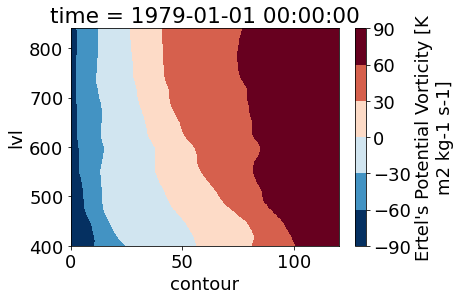

In [18]:
latEq[0].plot.contourf(x = 'contour')

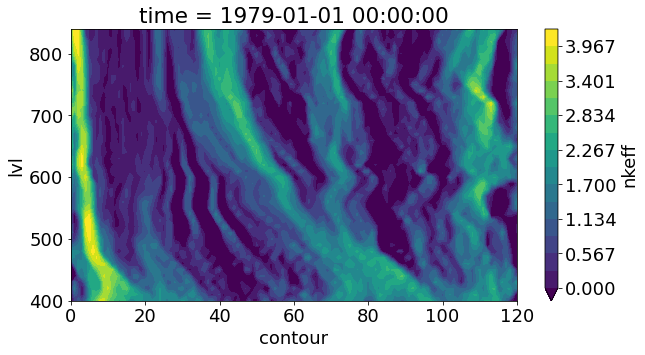

In [46]:
p = np.log(nkeff[0]).plot.contourf(figsize=(10, 5), levels=16, vmin=0)

In [50]:
preLats

array([-90., -89., -88., -87., -86., -85., -84., -83., -82., -81., -80.,
       -79., -78., -77., -76., -75., -74., -73., -72., -71., -70., -69.,
       -68., -67., -66., -65., -64., -63., -62., -61., -60., -59., -58.,
       -57., -56., -55., -54., -53., -52., -51., -50., -49., -48., -47.,
       -46., -45., -44., -43., -42., -41., -40., -39., -38., -37., -36.,
       -35., -34., -33., -32., -31., -30., -29., -28., -27., -26., -25.,
       -24., -23., -22., -21., -20., -19., -18., -17., -16., -15., -14.,
       -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,
        -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,
         9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,
        20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,
        31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,
        42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,
        53.,  54.,  55.,  56.,  57.,  58.,  59.,  6

In [47]:


#%% combined the results
# results in contour space
ds_contour = xr.merge([ctr, area, intgrdS, latEq, dintSdA, dqdA, Leq2, Lmin, nkeff])

# interpolate from contour space to equivalent-latitude space
preLats = np.linspace(-90, 90, 181).astype(dtype)
# results in latEq space
ds_latEq = analysis.interp_to_dataset(preLats, latEq, ds_contour)



In [36]:
(3.125-2.679)/2+3.125

3.348

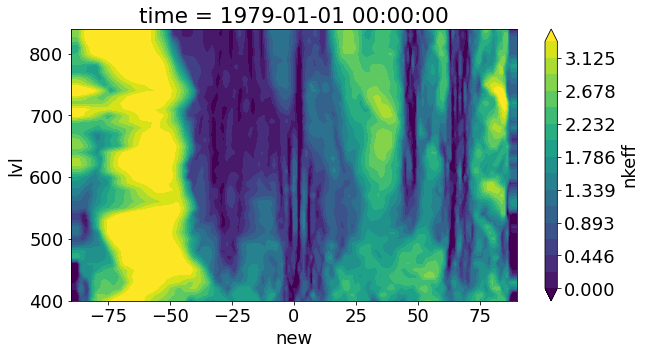

In [48]:
np.log(ds_latEq.nkeff[0]).plot.contourf(
    figsize=(10, 5), 
    levels=16, 
    vmin=0,
    vmax = 3.348
)

In [20]:
np.log(ds_latEq.nkeff[0]).plot.contourf(x = 'new', figsize=(10, 5), levels=16, vmin=0)

NameError: name 'ds_latEq' is not defined

In [35]:


#%% combined the results
# results in contour space
ds_contour = xr.merge([ctr, area, intgrdS, latEq, dintSdA, dqdA, Leq2, Lmin, nkeff])

# interpolate from contour space to equivalent-latitude space
preLats = np.linspace(-90, 90, 181).astype(dtype)
# results in latEq space
ds_latEq = analysis.interp_to_dataset(preLats, latEq, ds_contour)



In [25]:
# Calculate various diagnostics defined in contour-based coordinates
area    = analysis.cal_integral_within_contours(ctr, out_name='intArea')
intgrdS = analysis.cal_integral_within_contours(ctr, grdS, out_name='intgrdS')
latEq   = analysis.cal_equivalent_coords(area)
dgrdSdA = analysis.cal_gradient_wrt_area(intgrdS, area)
dqdA    = analysis.cal_gradient_wrt_area(ctr, area)
Leq2    = analysis.cal_sqared_equivalent_length(dgrdSdA, dqdA)
Lmin    = analysis.cal_minimum_possible_length(latEq)
nkeff   = analysis.cal_normalized_Keff(Leq2, Lmin)

TypeError: cal_integral_within_contours() got an unexpected keyword argument 'out_name'

In [24]:

# Collect all these as a xarray.Dataset defined on N contours
origin = xr.merge([ctr, area, intgrdS, latEq, dgrdSdA, dqdA, Leq2, Lmin, nkeff])

print(origin)

NameError: name 'dgrdSdA' is not defined

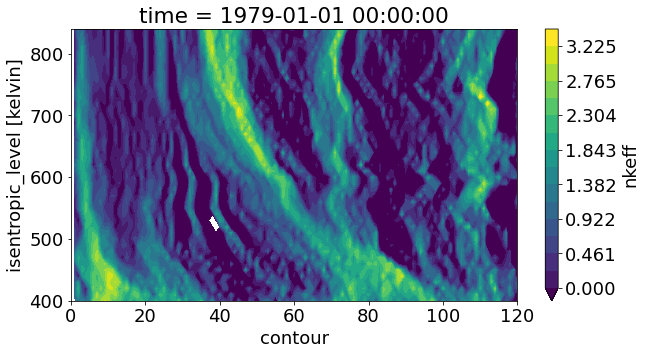

In [97]:
p = np.log(origin.nkeff[:]).plot.contourf(figsize=(10, 5), levels=16, vmin=0)

In [21]:
preLats = np.linspace(-90, 90, 181)
interp  = analysis.interp_to_dataset(preLats, latEq, origin)

print(interp)

# Select those levels above ground (400k above)
p = np.log(interp.nkeff[:]).plot.contourf(figsize=(10, 5), levels=16, vmin=0)
ax = p.ax#[0]
isent_data_xr['ua'].mean('lon').plot.contour(x = 'lat', ax = ax, colors = ('k'))

NameError: name 'origin' is not defined

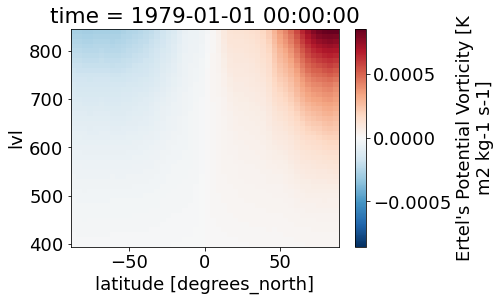

In [13]:
ds_out[0].mean('lon').plot(x = 'lat')

In [83]:
isent_data_xr['isentropic_level']


<xarray.DataArray 'isentropic_level' (isentropic_level: 45)>
array([400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530,
       540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670,
       680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810,
       820, 830, 840])
Coordinates:
  * isentropic_level  (isentropic_level) int64 400 410 420 430 ... 820 830 840
    time              object 1979-01-01 00:00:00
Attributes:
    units:     kelvin
    positive:  up

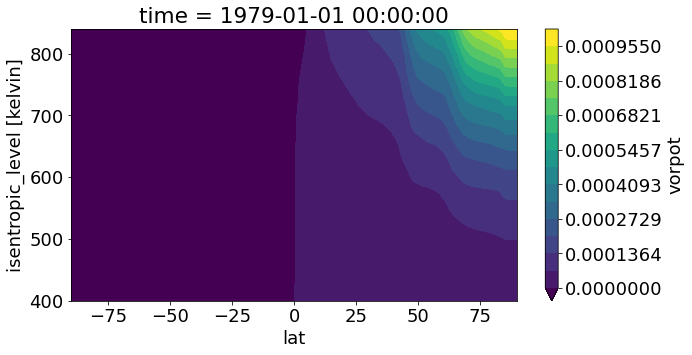

In [92]:
interp.vorpot.plot.contourf(figsize=(10, 5), levels=16, vmin=0)

In [ ]:
# Construct an analysis class using PV as the tracer
analysis = ContourAnalysisInLatLon(dset, tracer, grid)

# This should be called first to initialize contours from minimum value
# to maximum value (within lat/lon dims) using `N` contours.
N   = 121
ctr = analysis.cal_contours(N, dims=['latitude', 'longitude']).metpy.dequantify()

# Calculate various diagnostics defined in contour-based coordinates
area    = analysis.cal_integral_within_contours(ctr, out_name='intArea')
intgrdS = analysis.cal_integral_within_contours(ctr, grdS, out_name='intgrdS')
latEq   = analysis.cal_equivalent_coords(area)